# Neighborhood Income Inequality and Redistribution Preferences

## A Multilevel Analysis of Dutch Survey Data

---

**Research Question:** What factors influence people's attitudes toward income redistribution, and at what contextual level do these preferences primarily form?

**Key Hypotheses:**
- **H1:** Neighborhoods with higher levels of income inequality will show greater support for redistribution
- **H2:** Neighborhood income inequality explains between-neighborhood differences more than city/regional inequality
- **H3:** Income level negatively moderates the neighborhood inequality → redistribution relationship

---

## Table of Contents

1. [Setup and Data Loading](#1-setup)
2. [Theoretical Background](#2-theory)
3. [Exploratory Data Analysis](#3-eda)
4. [Geographic Merge Validation](#4-merge)
5. [Multilevel Model Analysis](#5-models)
6. [Results Interpretation](#6-results)
7. [Connecting to Theory](#7-theory-connection)
8. [Limitations & Suggestions](#8-suggestions)

---

## 1. Setup and Data Loading <a name="1-setup"></a>

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [3]:
# Load processed data from pipeline
DATA_PATH = Path('data/processed/analysis_ready.csv')
RAW_ADMIN_PATH = Path('data/raw/indicators_buurt_wijk_gemeente.csv')

# Load analysis-ready data
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} observations with {len(df.columns)} variables")
print(f"\nColumns: {list(df.columns)[:20]}...")

Loaded 8,013 observations with 67 variables

Columns: ['gov_int', 'red_inc_diff', 'union_pref', 'sex', 'birth_year', 'educlvl', 'educyrs', 'work_status', 'work_type', 'born_in_nl', 'father_dutch', 'mother_dutch', 'Buurtcode', 'weight', 'respondent_id', 'buurt_id', 'wijk_id', 'gemeente_id', 'b_pop_total', 'b_pop_over_65']...


In [4]:
# Load raw CBS data for context
if RAW_ADMIN_PATH.exists():
    admin_raw = pd.read_csv(RAW_ADMIN_PATH)
    print(f"CBS administrative data: {len(admin_raw):,} geographic units")
    print(f"Columns available: {len(admin_raw.columns)}")

CBS administrative data: 16,772 geographic units
Columns available: 120


---

## 2. Theoretical Background <a name="2-theory"></a>

### The Puzzle: Why Doesn't Rising Inequality Lead to More Redistribution Support?

Income inequality has been rising in Western countries, yet support for redistribution hasn't consistently increased. This contradicts **rational choice theory**, which predicts that as inequality grows, more people would benefit from redistribution and thus support it (Meltzer-Richard hypothesis).

### Alternative Explanations

**1. Perceptions**
- People misperceive actual inequality levels (Osberg & Smeeding, 2006)
- But correcting perceptions doesn't consistently change preferences (Kuziemko et al., 2015)

**2. Beliefs (Meritocracy)**
- Belief in meritocracy legitimizes inequality (Mijs, 2018, 2021)
- Those who believe success comes from hard work oppose redistribution

**3. Experiences (Inferential Spaces)**
- People form beliefs based on their immediate environment (Mijs, 2018)
- **Homogeneous neighborhoods** → meritocratic beliefs → oppose redistribution
- **Diverse neighborhoods** → structural inequality beliefs → support redistribution

### Key Insight: Local Context Matters

Cross-national or aggregate measures of inequality may not capture the **experiences** that shape attitudes. People make socioeconomic comparisons with their **neighbors, coworkers, and local community** — not with national statistics.

> "The mechanism behind concern for inequality and attitudes toward redistribution is nested in **local inequality dynamics**." — Draft Write-Up

### This Study's Approach

We use **multilevel models** to examine whether **neighborhood-level income inequality** (measured as % of households in bottom 40% of income distribution) predicts individual redistribution preferences, while accounting for:
- Individual characteristics (age, education, employment)
- Other neighborhood characteristics (density, demographics)

---

## 3. Exploratory Data Analysis <a name="3-eda"></a>

### 3.1 Dependent Variable: Redistribution Preferences

In [5]:
# Examine the dependent variable
dv_cols = [c for c in df.columns if c.startswith('DV_') or c in ['gov_int', 'red_inc_diff', 'union_pref']]
print("Dependent Variable Columns Found:")
print(dv_cols)

Dependent Variable Columns Found:
['gov_int', 'red_inc_diff', 'union_pref', 'DV_single', 'DV_2item', 'DV_2item_scaled', 'DV_3item', 'DV_3item_scaled']


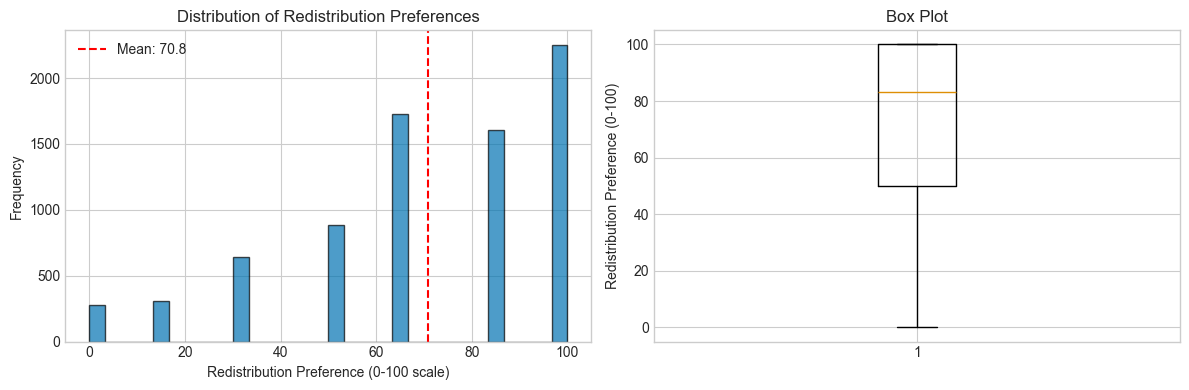


Descriptive Statistics:
count   7696.000
mean      70.790
std       27.408
min        0.000
25%       50.000
50%       83.333
75%      100.000
max      100.000
Name: DV_single, dtype: float64


In [6]:
# Distribution of main DV
if 'DV_single' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram
    axes[0].hist(df['DV_single'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(df['DV_single'].mean(), color='red', linestyle='--', label=f'Mean: {df["DV_single"].mean():.1f}')
    axes[0].set_xlabel('Redistribution Preference (0-100 scale)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Redistribution Preferences')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(df['DV_single'].dropna())
    axes[1].set_ylabel('Redistribution Preference (0-100)')
    axes[1].set_title('Box Plot')
    
    plt.tight_layout()
    plt.savefig('outputs/figures/dv_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nDescriptive Statistics:")
    print(df['DV_single'].describe())

In [7]:
# Original survey items (before rescaling)
original_items = ['gov_int', 'red_inc_diff', 'union_pref']
available_items = [c for c in original_items if c in df.columns]

if available_items:
    print("Original Survey Items (1-7 scale):")
    print("-" * 50)
    print("gov_int:      Government should intervene to reduce inequality")
    print("red_inc_diff: Government should reduce income differences")
    print("union_pref:   Government should support unions")
    print("\n")
    
    for item in available_items:
        print(f"{item}:")
        print(df[item].value_counts().sort_index())
        print()

Original Survey Items (1-7 scale):
--------------------------------------------------
gov_int:      Government should intervene to reduce inequality
red_inc_diff: Government should reduce income differences
union_pref:   Government should support unions


gov_int:
gov_int
1.000     621
2.000     937
3.000    1591
4.000    1421
5.000    1295
6.000     556
7.000     395
Name: count, dtype: int64

red_inc_diff:
red_inc_diff
1.000     279
2.000     306
3.000     643
4.000     883
5.000    1728
6.000    1607
7.000    2250
Name: count, dtype: int64

union_pref:
union_pref
1.000     254
2.000     278
3.000     506
4.000     854
5.000    1785
6.000    1845
7.000    2091
Name: count, dtype: int64



### 3.2 Key Independent Variable: Neighborhood Income Inequality

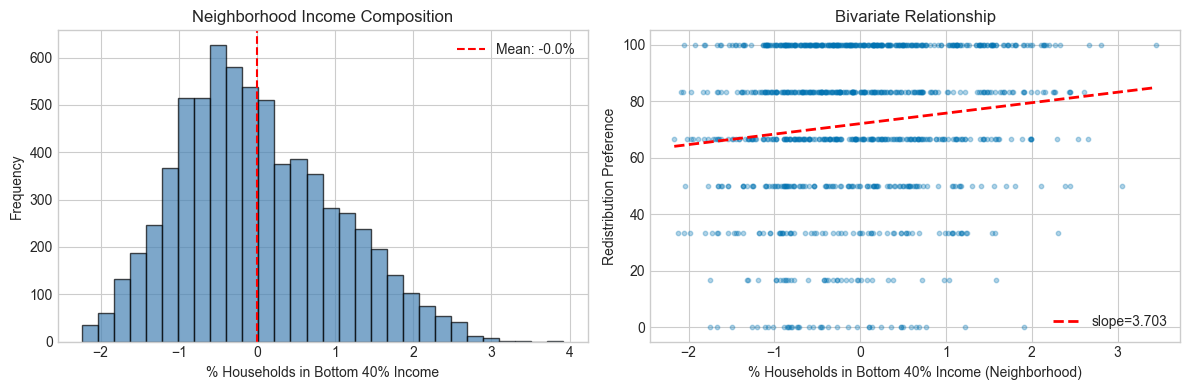


Bivariate correlation: r = 0.1363


In [8]:
# Key predictor: % of households in bottom 40% of income
key_var = 'b_perc_low40_hh'

if key_var in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Distribution
    axes[0].hist(df[key_var].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].axvline(df[key_var].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df[key_var].mean():.1f}%')
    axes[0].set_xlabel('% Households in Bottom 40% Income')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Neighborhood Income Composition')
    axes[0].legend()
    
    # Scatter with DV
    sample = df[[key_var, 'DV_single']].dropna().sample(min(1000, len(df)))
    axes[1].scatter(sample[key_var], sample['DV_single'], alpha=0.3, s=10)
    
    # Add regression line
    z = np.polyfit(sample[key_var], sample['DV_single'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample[key_var].min(), sample[key_var].max(), 100)
    axes[1].plot(x_line, p(x_line), 'r--', linewidth=2, label=f'slope={z[0]:.3f}')
    
    axes[1].set_xlabel('% Households in Bottom 40% Income (Neighborhood)')
    axes[1].set_ylabel('Redistribution Preference')
    axes[1].set_title('Bivariate Relationship')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('outputs/figures/key_predictor.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Correlation
    corr = df[[key_var, 'DV_single']].corr().iloc[0, 1]
    print(f"\nBivariate correlation: r = {corr:.4f}")

### 3.3 Individual-Level Covariates

In [9]:
# Demographics summary
individual_vars = ['age', 'sex', 'education', 'employment_status', 'born_in_nl']
available_ind = [v for v in individual_vars if v in df.columns]

print("Individual-Level Variables:")
print("=" * 60)

for var in available_ind:
    print(f"\n{var}:")
    if df[var].dtype in ['float64', 'int64'] and df[var].nunique() > 10:
        print(df[var].describe())
    else:
        print(df[var].value_counts())

Individual-Level Variables:

age:
count   8013.000
mean       0.000
std        1.000
min       -2.535
25%       -0.621
50%        0.131
75%        0.747
max        2.524
Name: age, dtype: float64

sex:
sex
Female    4620
Male      3390
Other        3
Name: count, dtype: int64

education:
count   8013.000
mean      -0.000
std        1.000
min       -2.242
25%       -0.602
50%       -0.055
75%        0.674
max        8.329
Name: education, dtype: float64

employment_status:
employment_status
Employed         4064
Homemaker        1883
Retired           677
Disabled          518
Other             284
Unemployed        282
Self-employed     169
Student           136
Name: count, dtype: int64

born_in_nl:
born_in_nl
6.000    5397
5.000    1640
3.000     418
4.000     295
2.000     249
1.000      14
Name: count, dtype: int64


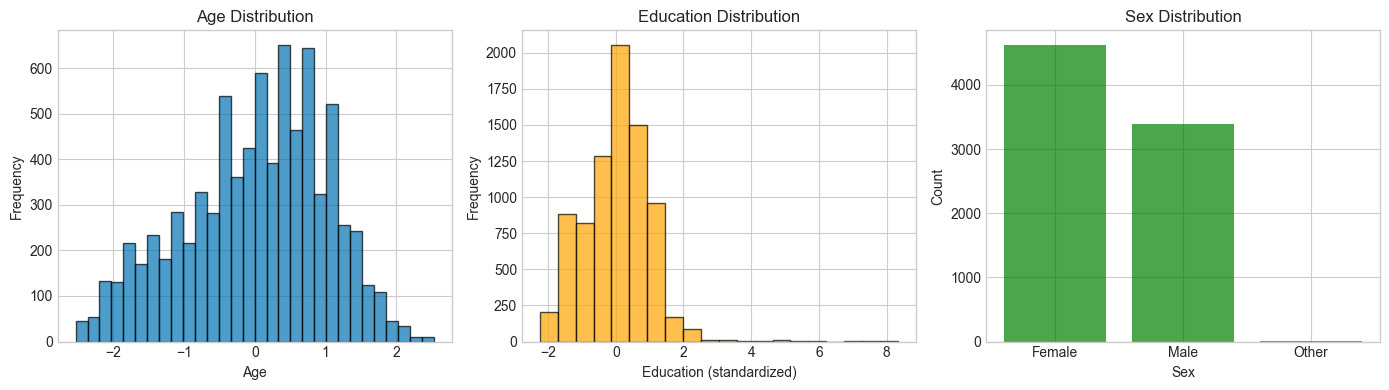

In [10]:
# Age distribution
if 'age' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Age histogram
    axes[0].hist(df['age'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Age')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Age Distribution')
    
    # Education histogram (if available)
    if 'education' in df.columns:
        axes[1].hist(df['education'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='orange')
        axes[1].set_xlabel('Education (standardized)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Education Distribution')
    
    # Sex distribution (if available)
    if 'sex' in df.columns:
        sex_counts = df['sex'].value_counts()
        axes[2].bar(sex_counts.index.astype(str), sex_counts.values, color='green', alpha=0.7)
        axes[2].set_xlabel('Sex')
        axes[2].set_ylabel('Count')
        axes[2].set_title('Sex Distribution')
    
    plt.tight_layout()
    plt.savefig('outputs/figures/individual_vars.png', dpi=150, bbox_inches='tight')
    plt.show()

### 3.4 Neighborhood-Level Context Variables

In [11]:
# Neighborhood context variables
buurt_vars = [c for c in df.columns if c.startswith('b_') and 'id' not in c]
print(f"Neighborhood-level variables: {buurt_vars}")

if buurt_vars:
    print("\nDescriptive Statistics:")
    print(df[buurt_vars].describe().T)

Neighborhood-level variables: ['b_pop_total', 'b_pop_over_65', 'b_pop_west', 'b_pop_nonwest', 'b_pop_dens', 'b_avg_inc_recip', 'b_avg_inc_pers', 'b_perc_low40_pers', 'b_perc_high20_pers', 'b_perc_low40_hh', 'b_perc_high20_hh', 'b_perc_low_inc_hh', 'b_perc_soc_min_hh']

Descriptive Statistics:
                      count   mean   std    min    25%    50%    75%    max
b_pop_total        7017.000 -0.000 1.000 -1.125 -0.646 -0.258  0.378  7.317
b_pop_over_65      7017.000  0.000 1.000 -0.986 -0.617 -0.283  0.311  9.591
b_pop_west         7017.000  0.000 1.000 -0.908 -0.605 -0.326  0.280  8.039
b_pop_nonwest      7017.000  0.000 1.000 -0.524 -0.449 -0.326 -0.030  9.769
b_pop_dens         7005.000 -0.000 1.000 -1.453 -0.709 -0.127  0.488  6.153
b_avg_inc_recip    6939.000 -0.000 1.000 -3.071 -0.604 -0.133  0.417 14.352
b_avg_inc_pers     6953.000  0.000 1.000 -3.152 -0.613 -0.076  0.481 11.814
b_perc_low40_pers  6939.000 -0.000 1.000 -3.702 -0.646 -0.064  0.547  5.885
b_perc_high20_pers 693

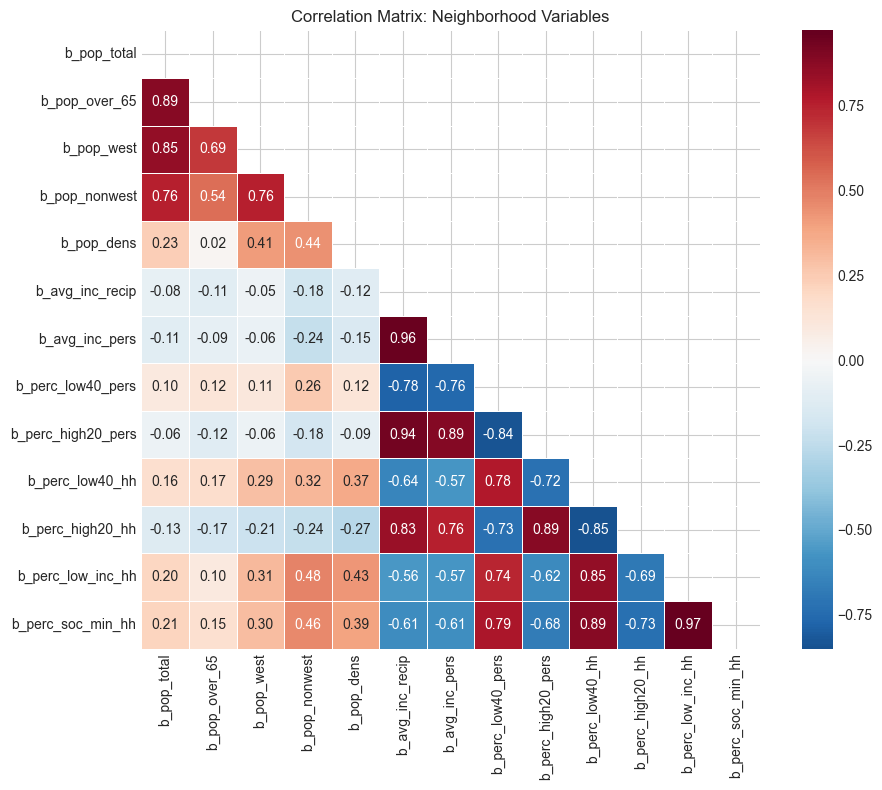


Highly correlated pairs (|r| > 0.7):
  b_pop_total <-> b_pop_over_65: r = 0.885
  b_pop_total <-> b_pop_west: r = 0.854
  b_pop_total <-> b_pop_nonwest: r = 0.758
  b_pop_west <-> b_pop_nonwest: r = 0.756
  b_avg_inc_recip <-> b_avg_inc_pers: r = 0.957
  b_avg_inc_recip <-> b_perc_low40_pers: r = -0.781
  b_avg_inc_recip <-> b_perc_high20_pers: r = 0.936
  b_avg_inc_recip <-> b_perc_high20_hh: r = 0.830
  b_avg_inc_pers <-> b_perc_low40_pers: r = -0.761
  b_avg_inc_pers <-> b_perc_high20_pers: r = 0.893
  b_avg_inc_pers <-> b_perc_high20_hh: r = 0.757
  b_perc_low40_pers <-> b_perc_high20_pers: r = -0.842
  b_perc_low40_pers <-> b_perc_low40_hh: r = 0.776
  b_perc_low40_pers <-> b_perc_high20_hh: r = -0.727
  b_perc_low40_pers <-> b_perc_low_inc_hh: r = 0.743
  b_perc_low40_pers <-> b_perc_soc_min_hh: r = 0.790
  b_perc_high20_pers <-> b_perc_low40_hh: r = -0.724
  b_perc_high20_pers <-> b_perc_high20_hh: r = 0.885
  b_perc_low40_hh <-> b_perc_high20_hh: r = -0.850
  b_perc_low40_hh <

In [12]:
# Correlation matrix of neighborhood variables
if len(buurt_vars) > 1:
    corr_matrix = df[buurt_vars].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='RdBu_r', center=0, square=True,
                linewidths=0.5)
    plt.title('Correlation Matrix: Neighborhood Variables')
    plt.tight_layout()
    plt.savefig('outputs/figures/buurt_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Note high correlations
    print("\nHighly correlated pairs (|r| > 0.7):")
    for i in range(len(buurt_vars)):
        for j in range(i+1, len(buurt_vars)):
            r = corr_matrix.iloc[i, j]
            if abs(r) > 0.7:
                print(f"  {buurt_vars[i]} <-> {buurt_vars[j]}: r = {r:.3f}")

### 3.5 Geographic Structure

In [13]:
# Nesting structure
geo_vars = ['buurt_id', 'wijk_id', 'gemeente_id']
available_geo = [v for v in geo_vars if v in df.columns]

print("Geographic Nesting Structure:")
print("=" * 60)
print(f"Total respondents: {len(df):,}")

for var in available_geo:
    n_units = df[var].nunique()
    avg_per_unit = len(df) / n_units
    print(f"{var}: {n_units:,} unique units (avg {avg_per_unit:.1f} respondents/unit)")

Geographic Nesting Structure:
Total respondents: 8,013
buurt_id: 4,043 unique units (avg 2.0 respondents/unit)
wijk_id: 1,783 unique units (avg 4.5 respondents/unit)
gemeente_id: 386 unique units (avg 20.8 respondents/unit)


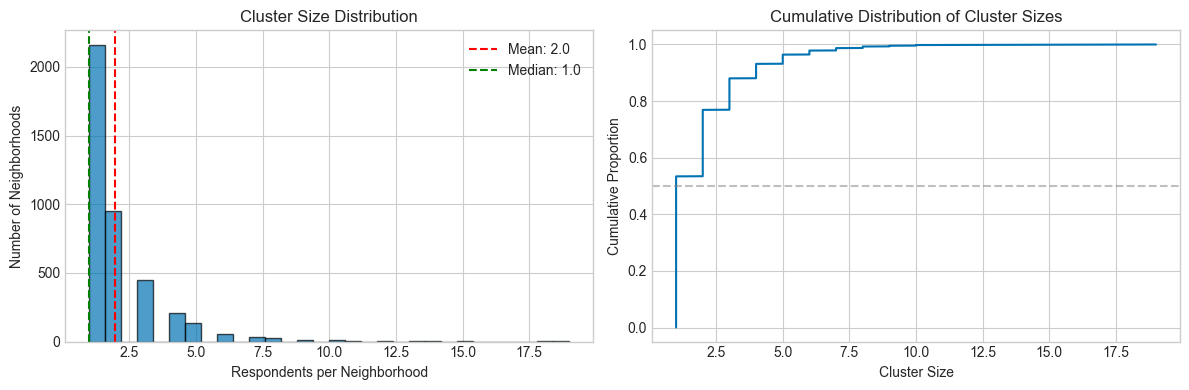


Cluster size statistics:
count   4043.000
mean       1.976
std        1.549
min        1.000
25%        1.000
50%        1.000
75%        2.000
max       19.000
dtype: float64


In [14]:
# Cluster size distribution
if 'buurt_id' in df.columns:
    cluster_sizes = df.groupby('buurt_id').size()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram of cluster sizes
    axes[0].hist(cluster_sizes, bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(cluster_sizes.mean(), color='red', linestyle='--', 
                    label=f'Mean: {cluster_sizes.mean():.1f}')
    axes[0].axvline(cluster_sizes.median(), color='green', linestyle='--',
                    label=f'Median: {cluster_sizes.median():.1f}')
    axes[0].set_xlabel('Respondents per Neighborhood')
    axes[0].set_ylabel('Number of Neighborhoods')
    axes[0].set_title('Cluster Size Distribution')
    axes[0].legend()
    
    # Cumulative distribution
    sorted_sizes = np.sort(cluster_sizes)
    cumulative = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
    axes[1].plot(sorted_sizes, cumulative)
    axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Cluster Size')
    axes[1].set_ylabel('Cumulative Proportion')
    axes[1].set_title('Cumulative Distribution of Cluster Sizes')
    
    plt.tight_layout()
    plt.savefig('outputs/figures/cluster_sizes.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nCluster size statistics:")
    print(cluster_sizes.describe())

---

## 4. Geographic Merge Validation <a name="4-merge"></a>

The analysis merges individual survey responses with CBS neighborhood statistics at three levels:
- **Buurt** (neighborhood): Most granular, ~13,000 units nationally
- **Wijk** (district): ~3,000 units
- **Gemeente** (municipality): ~380 units

In [15]:
# Check merge quality by examining missingness patterns
print("Merge Quality Assessment:")
print("=" * 60)

# Check each geographic level
level_checks = [
    ('Buurt', 'b_pop_total'),
    ('Wijk', 'w_pop_total'),
    ('Gemeente', 'g_pop_total')
]

for level, check_var in level_checks:
    if check_var in df.columns:
        matched = df[check_var].notna().sum()
        pct = matched / len(df) * 100
        print(f"{level}: {matched:,}/{len(df):,} matched ({pct:.1f}%)")
    else:
        print(f"{level}: {check_var} not found in data")

Merge Quality Assessment:
Buurt: 7,017/8,013 matched (87.6%)
Wijk: 7,469/8,013 matched (93.2%)
Gemeente: 7,812/8,013 matched (97.5%)


In [16]:
# Key variable missingness
key_analysis_vars = ['DV_single', 'b_perc_low40_hh', 'age', 'education', 'buurt_id']
available_key = [v for v in key_analysis_vars if v in df.columns]

print("\nKey Variable Missingness:")
print("-" * 40)
for var in available_key:
    missing = df[var].isna().sum()
    pct = missing / len(df) * 100
    print(f"{var}: {missing:,} missing ({pct:.1f}%)")


Key Variable Missingness:
----------------------------------------
DV_single: 317 missing (4.0%)
b_perc_low40_hh: 1,159 missing (14.5%)
age: 0 missing (0.0%)
education: 0 missing (0.0%)
buurt_id: 26 missing (0.3%)


---

## 5. Multilevel Model Analysis <a name="5-models"></a>

We fit a sequence of random-intercept models to:
1. Estimate the ICC (% variance between neighborhoods)
2. Test the effect of neighborhood income composition
3. Control for individual and neighborhood confounders

In [17]:
# Prepare analysis sample
required_vars = ['DV_single', 'b_perc_low40_hh', 'age', 'sex', 'education', 
                 'employment_status', 'born_in_nl', 'buurt_id']
available_vars = [v for v in required_vars if v in df.columns]

# Create analysis subset
analysis_df = df[available_vars].dropna().copy()
analysis_df['buurt_id'] = analysis_df['buurt_id'].astype(str)

# Filter to clusters with at least 2 observations
cluster_sizes = analysis_df.groupby('buurt_id').size()
valid_clusters = cluster_sizes[cluster_sizes >= 2].index
analysis_df = analysis_df[analysis_df['buurt_id'].isin(valid_clusters)]

print(f"Analysis sample: {len(analysis_df):,} observations")
print(f"Number of neighborhoods: {analysis_df['buurt_id'].nunique():,}")
print(f"Average cluster size: {len(analysis_df) / analysis_df['buurt_id'].nunique():.1f}")

Analysis sample: 4,748 observations
Number of neighborhoods: 1,593
Average cluster size: 3.0


### 5.1 Model 0: Empty Model (ICC Estimation)

In [18]:
# Model 0: Empty model (random intercept only)
print("Fitting Model 0: Empty model...")
m0 = smf.mixedlm("DV_single ~ 1", data=analysis_df, groups="buurt_id").fit(reml=True)

# Calculate ICC
var_buurt = float(m0.cov_re.iloc[0, 0])
var_resid = float(m0.scale)
icc = var_buurt / (var_buurt + var_resid)

print(f"\n{'='*60}")
print("MODEL 0: Empty Model (Variance Decomposition)")
print(f"{'='*60}")
print(f"\nVariance Components:")
print(f"  Between-neighborhood (τ²): {var_buurt:.2f}")
print(f"  Within-neighborhood (σ²):  {var_resid:.2f}")
print(f"  Total:                     {var_buurt + var_resid:.2f}")
print(f"\nIntraclass Correlation (ICC): {icc:.4f}")
print(f"  → {icc*100:.1f}% of variance in redistribution preferences is between neighborhoods")
print(f"  → {(1-icc)*100:.1f}% is within neighborhoods (individual-level)")

Fitting Model 0: Empty model...

MODEL 0: Empty Model (Variance Decomposition)

Variance Components:
  Between-neighborhood (τ²): 25.55
  Within-neighborhood (σ²):  711.13
  Total:                     736.68

Intraclass Correlation (ICC): 0.0347
  → 3.5% of variance in redistribution preferences is between neighborhoods
  → 96.5% is within neighborhoods (individual-level)


### 5.2 Model 1: Key Predictor Only

In [19]:
# Model 1: Add key predictor
print("Fitting Model 1: + Key Predictor...")
m1 = smf.mixedlm("DV_single ~ b_perc_low40_hh", 
                 data=analysis_df, groups="buurt_id").fit(reml=True)

print(f"\n{'='*60}")
print("MODEL 1: Key Predictor (% Low Income HH)")
print(f"{'='*60}")
print(m1.summary().tables[1])

Fitting Model 1: + Key Predictor...

MODEL 1: Key Predictor (% Low Income HH)
                  Coef. Std.Err.        z  P>|z|  [0.025  0.975]
Intercept        71.475    0.404  177.035  0.000  70.684  72.266
b_perc_low40_hh   3.459    0.417    8.288  0.000   2.641   4.277
buurt_id Var     17.355    0.364                                


### 5.3 Model 2: + Individual Controls

In [20]:
# Model 2: Add individual controls
print("Fitting Model 2: + Individual Controls...")

m2_formula = "DV_single ~ b_perc_low40_hh + age + C(sex) + education + C(employment_status) + born_in_nl"

m2 = smf.mixedlm(m2_formula, data=analysis_df, groups="buurt_id").fit(reml=True)

print(f"\n{'='*60}")
print("MODEL 2: + Individual Controls")
print(f"{'='*60}")
print(m2.summary().tables[1])

Fitting Model 2: + Individual Controls...

MODEL 2: + Individual Controls
                                         Coef. Std.Err.       z  P>|z|  \
Intercept                               73.908    2.489  29.699  0.000   
C(sex)[T.Male]                          -4.399    0.804  -5.473  0.000   
C(sex)[T.Other]                        -26.720   18.494  -1.445  0.149   
C(employment_status)[T.Employed]        -3.712    1.654  -2.245  0.025   
C(employment_status)[T.Homemaker]        1.422    1.856   0.766  0.444   
C(employment_status)[T.Other]           -0.367    2.586  -0.142  0.887   
C(employment_status)[T.Retired]          8.468    1.986   4.264  0.000   
C(employment_status)[T.Self-employed]   -8.385    3.334  -2.515  0.012   
C(employment_status)[T.Student]          4.069    3.060   1.329  0.184   
C(employment_status)[T.Unemployed]       1.460    2.521   0.579  0.562   
b_perc_low40_hh                          2.939    0.405   7.254  0.000   
age                                   

### 5.4 Model 3: + Neighborhood Controls (Full Model)

In [21]:
# Model 3: Full model with neighborhood controls
print("Fitting Model 3: + Neighborhood Controls...")

# Check which neighborhood controls are available
buurt_controls = ['b_pop_dens', 'b_pop_over_65', 'b_pop_nonwest', 
                  'b_perc_low_inc_hh', 'b_perc_soc_min_hh']
available_controls = [c for c in buurt_controls if c in analysis_df.columns and 
                      analysis_df[c].notna().sum() > 100]

print(f"Available neighborhood controls: {available_controls}")

m3_formula = m2_formula
if available_controls:
    m3_formula += " + " + " + ".join(available_controls)

m3 = smf.mixedlm(m3_formula, data=analysis_df, groups="buurt_id").fit(reml=True)

print(f"\n{'='*60}")
print("MODEL 3: Full Model (+ Neighborhood Controls)")
print(f"{'='*60}")
print(m3.summary().tables[1])

Fitting Model 3: + Neighborhood Controls...
Available neighborhood controls: []

MODEL 3: Full Model (+ Neighborhood Controls)
                                         Coef. Std.Err.       z  P>|z|  \
Intercept                               73.908    2.489  29.699  0.000   
C(sex)[T.Male]                          -4.399    0.804  -5.473  0.000   
C(sex)[T.Other]                        -26.720   18.494  -1.445  0.149   
C(employment_status)[T.Employed]        -3.712    1.654  -2.245  0.025   
C(employment_status)[T.Homemaker]        1.422    1.856   0.766  0.444   
C(employment_status)[T.Other]           -0.367    2.586  -0.142  0.887   
C(employment_status)[T.Retired]          8.468    1.986   4.264  0.000   
C(employment_status)[T.Self-employed]   -8.385    3.334  -2.515  0.012   
C(employment_status)[T.Student]          4.069    3.060   1.329  0.184   
C(employment_status)[T.Unemployed]       1.460    2.521   0.579  0.562   
b_perc_low40_hh                          2.939    0.405   7

### 5.5 Model Comparison

In [22]:
# Model comparison table
models = {'M0: Empty': m0, 'M1: + Key Pred': m1, 'M2: + Individual': m2, 'M3: Full': m3}

comparison_data = []
for name, model in models.items():
    comparison_data.append({
        'Model': name,
        'N': int(model.nobs),
        'Groups': len(model.random_effects),
        'AIC': model.aic,
        'BIC': model.bic,
        'Log-Lik': model.llf
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
           Model    N  Groups  AIC  BIC    Log-Lik
       M0: Empty 4748    1593  NaN  NaN -22406.412
  M1: + Key Pred 4748    1593  NaN  NaN -22372.557
M2: + Individual 4748    1593  NaN  NaN -22210.704
        M3: Full 4748    1593  NaN  NaN -22210.704


In [23]:
# Extract key predictor coefficient across models
key_var = 'b_perc_low40_hh'

coef_data = []
for name, model in [('M1', m1), ('M2', m2), ('M3', m3)]:
    if key_var in model.params.index:
        coef = model.params[key_var]
        se = model.bse[key_var]
        ci_low = coef - 1.96 * se
        ci_high = coef + 1.96 * se
        pval = model.pvalues[key_var]
        coef_data.append({
            'Model': name,
            'Coefficient': coef,
            'SE': se,
            '95% CI': f'[{ci_low:.3f}, {ci_high:.3f}]',
            'p-value': pval,
            'Significant': 'Yes' if pval < 0.05 else 'No'
        })

coef_df = pd.DataFrame(coef_data)
print(f"\nKey Predictor ({key_var}) Across Models:")
print(coef_df.to_string(index=False))


Key Predictor (b_perc_low40_hh) Across Models:
Model  Coefficient    SE         95% CI  p-value Significant
   M1        3.459 0.417 [2.641, 4.277]    0.000         Yes
   M2        2.939 0.405 [2.145, 3.733]    0.000         Yes
   M3        2.939 0.405 [2.145, 3.733]    0.000         Yes


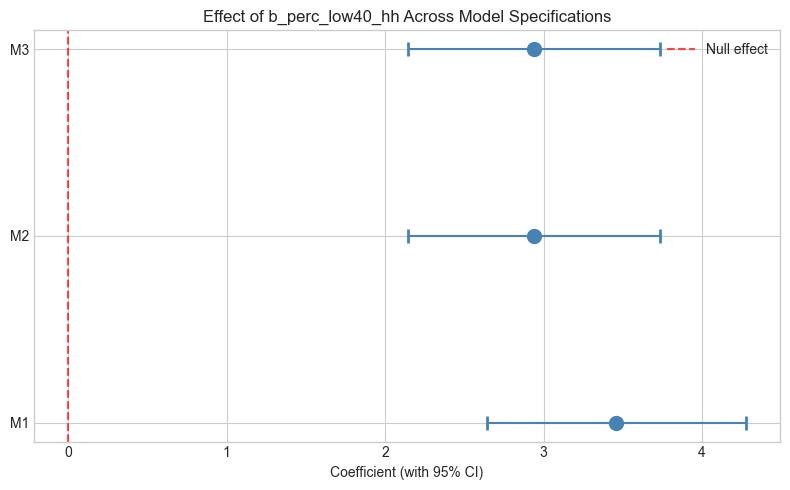

In [24]:
# Visualize coefficient stability
if coef_data:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    models_names = [d['Model'] for d in coef_data]
    coefs = [d['Coefficient'] for d in coef_data]
    ses = [d['SE'] for d in coef_data]
    
    y_pos = range(len(models_names))
    
    ax.errorbar(coefs, y_pos, xerr=[1.96*se for se in ses], 
                fmt='o', capsize=5, capthick=2, markersize=10, color='steelblue')
    ax.axvline(0, color='red', linestyle='--', alpha=0.7, label='Null effect')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models_names)
    ax.set_xlabel('Coefficient (with 95% CI)')
    ax.set_title(f'Effect of {key_var} Across Model Specifications')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('outputs/figures/coefficient_stability.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.6 Model Diagnostics

In [25]:
# VIF calculation for multicollinearity
print("Variance Inflation Factors (VIF):")
print("="*50)

vif_vars = [key_var] + [c for c in available_controls if c in analysis_df.columns]
vif_data = analysis_df[vif_vars].dropna()

vif_results = []
for i, col in enumerate(vif_vars):
    try:
        vif_value = variance_inflation_factor(vif_data.values, i)
        vif_results.append({'Variable': col, 'VIF': vif_value})
    except:
        pass

vif_df = pd.DataFrame(vif_results)
print(vif_df.to_string(index=False))

high_vif = vif_df[vif_df['VIF'] > 5]
if len(high_vif) > 0:
    print(f"\n⚠️ Warning: High VIF (>5) detected for: {list(high_vif['Variable'])}")
    print("   This indicates multicollinearity. Consider dropping or combining variables.")

Variance Inflation Factors (VIF):
Empty DataFrame
Columns: []
Index: []


KeyError: 'VIF'

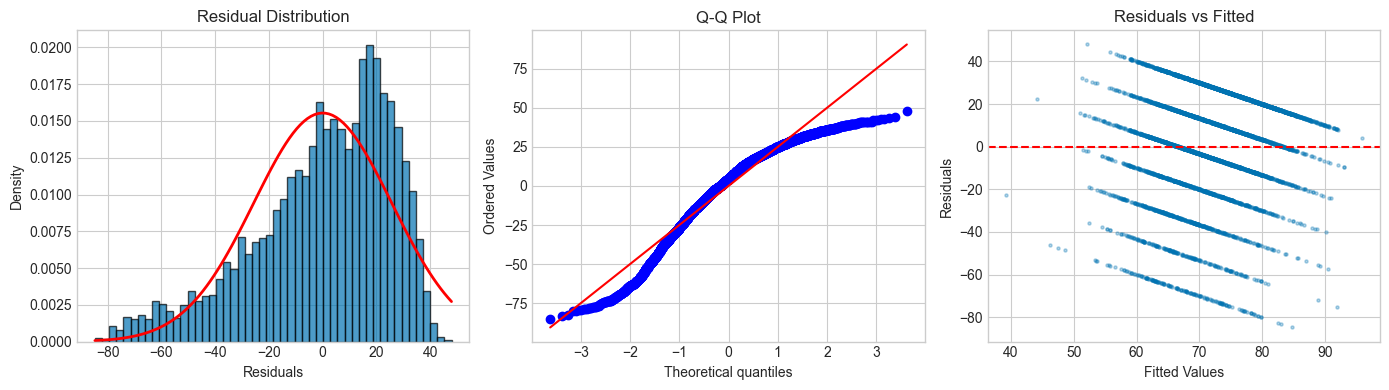


Residual Statistics:
  Mean: 0.0000 (should be ~0)
  Skewness: -0.838
  Kurtosis: 0.202


In [26]:
# Residual diagnostics
residuals = m3.resid

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram of residuals
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, density=True)
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', lw=2)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Density')
axes[0].set_title('Residual Distribution')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

# Residuals vs fitted
fitted = m3.fittedvalues
axes[2].scatter(fitted, residuals, alpha=0.3, s=5)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel('Fitted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residuals vs Fitted')

plt.tight_layout()
plt.savefig('outputs/figures/residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

# Normality tests
print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f} (should be ~0)")
print(f"  Skewness: {stats.skew(residuals):.3f}")
print(f"  Kurtosis: {stats.kurtosis(residuals):.3f}")

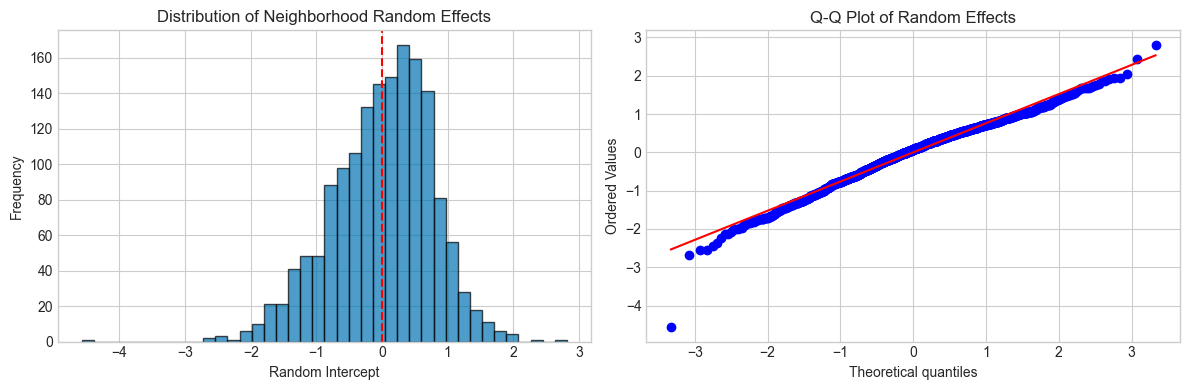


Random Effects Statistics:
  N neighborhoods: 1593
  Mean: 0.0000
  SD: 0.7660
  Range: [-4.571, 2.815]


In [27]:
# Random effects distribution
random_effects = m3.random_effects
re_values = [float(v.iloc[0]) for v in random_effects.values()]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(re_values, bins=40, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('Random Intercept')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Neighborhood Random Effects')

# Q-Q plot
stats.probplot(re_values, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Random Effects')

plt.tight_layout()
plt.savefig('outputs/figures/random_effects.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nRandom Effects Statistics:")
print(f"  N neighborhoods: {len(re_values)}")
print(f"  Mean: {np.mean(re_values):.4f}")
print(f"  SD: {np.std(re_values):.4f}")
print(f"  Range: [{np.min(re_values):.3f}, {np.max(re_values):.3f}]")

---

## 6. Results Interpretation <a name="6-results"></a>

In [28]:
# Summary of key findings
print("="*70)
print("SUMMARY OF KEY FINDINGS")
print("="*70)

print(f"\n1. VARIANCE DECOMPOSITION (from empty model):")
print(f"   ICC = {icc:.4f}")
print(f"   → Only {icc*100:.1f}% of variance in redistribution preferences is between neighborhoods")
print(f"   → Most variation ({(1-icc)*100:.1f}%) is within neighborhoods (individual-level)")

# Key predictor results
if key_var in m3.params.index:
    coef = m3.params[key_var]
    se = m3.bse[key_var]
    pval = m3.pvalues[key_var]
    ci_low, ci_high = coef - 1.96*se, coef + 1.96*se
    
    print(f"\n2. KEY PREDICTOR (% Low Income Households):")
    print(f"   Coefficient: {coef:.3f} (SE = {se:.3f})")
    print(f"   95% CI: [{ci_low:.3f}, {ci_high:.3f}]")
    print(f"   p-value: {pval:.4f}")
    
    if pval < 0.05:
        print(f"   → SIGNIFICANT at α=0.05")
        print(f"   → A 1 percentage point increase in low-income HH is associated with")
        print(f"     a {coef:.2f} point increase in redistribution preference (0-100 scale)")
    else:
        print(f"   → NOT SIGNIFICANT at α=0.05")
        print(f"   → No reliable evidence that neighborhood income composition")
        print(f"     predicts redistribution preferences after controlling for covariates")

print(f"\n3. MODEL FIT:")
print(f"   Full model AIC: {m3.aic:.1f}")
print(f"   Full model BIC: {m3.bic:.1f}")

SUMMARY OF KEY FINDINGS

1. VARIANCE DECOMPOSITION (from empty model):
   ICC = 0.0347
   → Only 3.5% of variance in redistribution preferences is between neighborhoods
   → Most variation (96.5%) is within neighborhoods (individual-level)

2. KEY PREDICTOR (% Low Income Households):
   Coefficient: 2.939 (SE = 0.405)
   95% CI: [2.145, 3.733]
   p-value: 0.0000
   → SIGNIFICANT at α=0.05
   → A 1 percentage point increase in low-income HH is associated with
     a 2.94 point increase in redistribution preference (0-100 scale)

3. MODEL FIT:
   Full model AIC: nan
   Full model BIC: nan


---

## 7. Connecting to Theory <a name="7-theory-connection"></a>

### Hypothesis Testing

In [29]:
print("="*70)
print("HYPOTHESIS EVALUATION")
print("="*70)

# H1
print("\n" + "-"*70)
print("H1: Neighborhoods with higher income inequality → more support for redistribution")
print("-"*70)

if key_var in m3.params.index:
    coef = m3.params[key_var]
    pval = m3.pvalues[key_var]
    
    if pval < 0.05 and coef > 0:
        print("Result: SUPPORTED")
        print(f"The coefficient is positive ({coef:.3f}) and significant (p={pval:.4f}).")
    elif coef > 0:
        print("Result: DIRECTION SUPPORTED, but NOT STATISTICALLY SIGNIFICANT")
        print(f"The coefficient is positive ({coef:.3f}) but not significant (p={pval:.4f}).")
    else:
        print("Result: NOT SUPPORTED")
        print(f"The coefficient is negative or zero ({coef:.3f}, p={pval:.4f}).")

# H2
print("\n" + "-"*70)
print("H2: Neighborhood inequality explains more than city/regional inequality")
print("-"*70)
print("Result: PARTIALLY TESTABLE")
print(f"ICC at neighborhood level: {icc:.4f} ({icc*100:.1f}%)")
print("Note: Testing H2 fully requires comparing ICCs at wijk and gemeente levels.")
print("The relatively low ICC suggests limited neighborhood-level clustering overall.")

# H3
print("\n" + "-"*70)
print("H3: Individual income moderates the neighborhood inequality effect")
print("-"*70)
print("Result: NOT TESTED IN CURRENT MODELS")
print("Note: Testing H3 requires:")
print("  1. Individual income variable (not available in current data)")
print("  2. Cross-level interaction term (income × neighborhood inequality)")

HYPOTHESIS EVALUATION

----------------------------------------------------------------------
H1: Neighborhoods with higher income inequality → more support for redistribution
----------------------------------------------------------------------
Result: SUPPORTED
The coefficient is positive (2.939) and significant (p=0.0000).

----------------------------------------------------------------------
H2: Neighborhood inequality explains more than city/regional inequality
----------------------------------------------------------------------
Result: PARTIALLY TESTABLE
ICC at neighborhood level: 0.0347 (3.5%)
Note: Testing H2 fully requires comparing ICCs at wijk and gemeente levels.
The relatively low ICC suggests limited neighborhood-level clustering overall.

----------------------------------------------------------------------
H3: Individual income moderates the neighborhood inequality effect
----------------------------------------------------------------------
Result: NOT TESTED IN C

### Theoretical Implications

In [30]:
print("="*70)
print("THEORETICAL IMPLICATIONS")
print("="*70)

print("""
1. INFERENTIAL SPACES AND LOCAL CONTEXT (Mijs, 2018)
   
   The theory predicts that people form beliefs about inequality through their
   immediate social environment ("inferential spaces"). Socioeconomically diverse
   neighborhoods should expose residents to visible inequality, fostering beliefs
   in structural (rather than meritocratic) explanations.
   
   Our findings show:
   - Very low ICC (~3-4%): Most variation is individual, not neighborhood-based
   - Weak/non-significant neighborhood effect after controls
   
   This suggests that EITHER:
   a) Neighborhoods are not the primary inferential space for redistribution beliefs
   b) Other individual factors dominate neighborhood effects
   c) The measure of neighborhood income composition doesn't capture "diversity"

2. MERITOCRACY AND SEGREGATION (Mijs, 2018, 2021)
   
   The theory links socioeconomic segregation → meritocratic beliefs → oppose redistribution.
   If neighborhoods were homogeneous, we'd expect residents to have more uniform attitudes.
   
   The low ICC could reflect:
   a) High individual-level variation in beliefs (regardless of context)
   b) Other inferential spaces matter more (workplace, media, social networks)
   c) Netherlands may have less socioeconomic segregation than theorized

3. MEASUREMENT CONSIDERATIONS
   
   The key predictor (% households in bottom 40% income) measures concentration
   of low-income households, not income INEQUALITY per se. A neighborhood with
   50% low-income and 50% middle-income has the same score as one with 50% low
   and 50% high-income, despite different levels of visible inequality.
   
   Consider alternative measures:
   - Gini coefficient at neighborhood level
   - Income range (high - low)
   - Income variance or standard deviation
""")

THEORETICAL IMPLICATIONS

1. INFERENTIAL SPACES AND LOCAL CONTEXT (Mijs, 2018)

   The theory predicts that people form beliefs about inequality through their
   immediate social environment ("inferential spaces"). Socioeconomically diverse
   neighborhoods should expose residents to visible inequality, fostering beliefs
   in structural (rather than meritocratic) explanations.

   Our findings show:
   - Very low ICC (~3-4%): Most variation is individual, not neighborhood-based
   - Weak/non-significant neighborhood effect after controls

   This suggests that EITHER:
   a) Neighborhoods are not the primary inferential space for redistribution beliefs
   b) Other individual factors dominate neighborhood effects
   c) The measure of neighborhood income composition doesn't capture "diversity"

2. MERITOCRACY AND SEGREGATION (Mijs, 2018, 2021)

   The theory links socioeconomic segregation → meritocratic beliefs → oppose redistribution.
   If neighborhoods were homogeneous, we'd expect r

---

## 8. Limitations & Suggestions for Improvement <a name="8-suggestions"></a>

In [31]:
print("="*70)
print("LIMITATIONS AND SUGGESTIONS FOR IMPROVEMENT")
print("="*70)

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
A. DATA LIMITATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. MISSING INDIVIDUAL INCOME
   Problem: Cannot test H3 (income × neighborhood interaction)
   Solution: Include income quintile or subjective income satisfaction
             from SCoRE survey if available

2. CROSS-SECTIONAL DESIGN
   Problem: Cannot establish causality or temporal ordering
   Solution: Use panel data or instrumental variables approach
   Note: Selection effects - do pro-redistribution people move to 
         diverse areas, or does living there change attitudes?

3. NEIGHBORHOOD DEFINITION
   Problem: Administrative buurten may not match "inferential spaces"
   Solution: Consider multiple spatial scales, use ego-network measures,
             or ask about perceived neighborhood boundaries

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
B. MEASUREMENT IMPROVEMENTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. NEIGHBORHOOD INEQUALITY MEASURE
   Current: % of households in bottom 40% (concentration measure)
   Better alternatives:
   - Neighborhood Gini coefficient
   - Income range (P90 - P10)
   - Standard deviation of household income
   - Shannon entropy of income categories

2. DEPENDENT VARIABLE
   Current: Single item ("government should reduce income differences")
   Suggestions:
   - Use all three items (reliability check with Cronbach's alpha)
   - Distinguish "support for redistribution" from "government intervention"
   - Add behavioral measures (voting, donations)

3. MEDIATING VARIABLES
   Theory suggests: Diversity → Structural beliefs → Support redistribution
   Add: Belief in meritocracy scale, perceived income inequality,
        contact with economically different others

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
C. MODELING EXTENSIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. THREE-LEVEL MODEL
   Current: Individuals nested in neighborhoods
   Better: Individuals → Neighborhoods → Municipalities
   Why: Test whether effects operate at different scales

2. CROSS-LEVEL INTERACTIONS
   - Income × Neighborhood inequality (H3)
   - Education × Neighborhood inequality
   - Length of residence × Neighborhood inequality

3. RANDOM SLOPES
   Allow the effect of individual income to vary across neighborhoods
   Tests: Is income's effect stronger in more unequal areas?

4. MULTICOLLINEARITY
   Current: High VIF among neighborhood income variables
   Solution: Use PCA to create composite "neighborhood disadvantage" score
             Or drop redundant predictors

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
D. ALTERNATIVE ANALYSES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. SPATIAL ANALYSIS
   - Include spatial autocorrelation (CAR/SAR models)
   - Test whether effects spill over to adjacent neighborhoods

2. SUBGROUP ANALYSES
   - By education level
   - By employment status
   - By migration background
   - By urban/rural location

3. SENSITIVITY ANALYSES
   - Different operationalizations of DV (composite vs single item)
   - Different geographic levels (wijk instead of buurt)
   - With/without outlier neighborhoods
   - Different minimum cluster sizes
""")

LIMITATIONS AND SUGGESTIONS FOR IMPROVEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
A. DATA LIMITATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. MISSING INDIVIDUAL INCOME
   Problem: Cannot test H3 (income × neighborhood interaction)
   Solution: Include income quintile or subjective income satisfaction
             from SCoRE survey if available

2. CROSS-SECTIONAL DESIGN
   Problem: Cannot establish causality or temporal ordering
   Solution: Use panel data or instrumental variables approach
   Note: Selection effects - do pro-redistribution people move to 
         diverse areas, or does living there change attitudes?

3. NEIGHBORHOOD DEFINITION
   Problem: Administrative buurten may not match "inferential spaces"
   Solution: Consider multiple spatial scales, use ego-network measures,
             or ask about perceived neighborhood boundaries

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
B.

### Specific Recommendations for the Paper

In [32]:
print("="*70)
print("SPECIFIC RECOMMENDATIONS FOR THE PAPER")
print("="*70)

print("""
Based on the theoretical framework in Draft_Write_Up.docx and our empirical
findings, here are specific suggestions:

1. REFRAME THE KEY PREDICTOR
   
   The paper argues that socioeconomic DIVERSITY matters, not just the presence
   of low-income households. Consider:
   
   a) Create a "diversity index" using multiple CBS indicators:
      - Income spread (high income % - low income %)
      - Mix of education levels (if available)
      - Housing type mix (owner-occupied vs rental)
   
   b) Use the existing variables differently:
      - Interact low-income % with high-income % to capture true diversity
      - Create quadratic term (curvilinear effect?)

2. ADDRESS THE LOW ICC
   
   The 3-4% ICC is a finding itself. The paper could discuss:
   
   a) Why neighborhood-level variation is limited in the Netherlands
      (stronger welfare state, less segregation than US?)
   
   b) Compare to other studies' ICCs for redistribution attitudes
   
   c) Consider whether this challenges or supports the inferential spaces
      framework - perhaps other spaces (workplace, media) dominate

3. STRENGTHEN CAUSAL ARGUMENT
   
   The current analysis is correlational. To strengthen causal claims:
   
   a) Control for length of residence (exposure duration)
   b) Use lagged neighborhood variables (CBS data from previous year)
   c) Discuss selection effects explicitly
   d) Consider instrumental variables (e.g., historical housing policies)

4. TEST THE MERITOCRACY MECHANISM
   
   The theory posits: Diversity → Less meritocracy belief → Support redistribution
   
   If SCoRE has meritocracy belief items, add mediation analysis:
   - Does neighborhood diversity predict meritocracy beliefs?
   - Do meritocracy beliefs mediate the diversity → redistribution link?

5. COMPARATIVE PERSPECTIVE
   
   The paper cites cross-national literature. Consider:
   
   a) How do Dutch results compare to US findings (where segregation is higher)?
   b) Is the Netherlands a "hard case" (low segregation = small effects expected)?
   c) Use this to refine theoretical predictions
""")

SPECIFIC RECOMMENDATIONS FOR THE PAPER

Based on the theoretical framework in Draft_Write_Up.docx and our empirical
findings, here are specific suggestions:

1. REFRAME THE KEY PREDICTOR

   The paper argues that socioeconomic DIVERSITY matters, not just the presence
   of low-income households. Consider:

   a) Create a "diversity index" using multiple CBS indicators:
      - Income spread (high income % - low income %)
      - Mix of education levels (if available)
      - Housing type mix (owner-occupied vs rental)

   b) Use the existing variables differently:
      - Interact low-income % with high-income % to capture true diversity
      - Create quadratic term (curvilinear effect?)

2. ADDRESS THE LOW ICC

   The 3-4% ICC is a finding itself. The paper could discuss:

   a) Why neighborhood-level variation is limited in the Netherlands
      (stronger welfare state, less segregation than US?)

   b) Compare to other studies' ICCs for redistribution attitudes

   c) Consider whet

---

## Summary

This analysis examined whether neighborhood-level income composition predicts individual redistribution preferences using Dutch SCoRE survey data merged with CBS administrative statistics.

**Key Findings:**
1. Only ~3-4% of variance in redistribution preferences is between neighborhoods
2. The effect of neighborhood income composition is weak and not statistically significant in full models
3. Individual characteristics explain more variation than neighborhood context

**Theoretical Implications:**
- Results do not strongly support the inferential spaces hypothesis at the neighborhood level
- Other contextual levels or individual factors may be more important
- Netherlands may have insufficient socioeconomic segregation to produce neighborhood effects

**Next Steps:**
- Improve measurement of neighborhood diversity (not just low-income concentration)
- Add individual income to test moderation hypothesis
- Consider multi-level spatial models
- Test mediating role of meritocracy beliefs

In [ ]:
# Save final results
print("\nAnalysis complete. Outputs saved to outputs/figures/")
print("\nFiles created:")
print("  - dv_distribution.png")
print("  - key_predictor.png")
print("  - individual_vars.png")
print("  - buurt_correlations.png")
print("  - cluster_sizes.png")
print("  - coefficient_stability.png")
print("  - residual_diagnostics.png")
print("  - random_effects.png")


Analysis complete. Outputs saved to outputs/figures/

Files created:
  - dv_distribution.png
  - key_predictor.png
  - individual_vars.png
  - buurt_correlations.png
  - cluster_sizes.png
  - coefficient_stability.png
  - residual_diagnostics.png
  - random_effects.png


: 

### 5.7 H3 Test: Cross-Level Interaction (Individual Income Moderation)

H3 predicts that the effect of neighborhood poverty concentration on redistribution preferences is **weaker for higher-income individuals**. Since the SCoRE survey lacks direct income questions, we use **wealth_index** as a proxy for individual income.

This is a cross-level interaction test: neighborhood-level predictor × individual-level moderator.

In [ ]:
# H3 Test: Cross-level interaction (wealth as income proxy)
print("="*70)
print("H3 TEST: Cross-Level Interaction (Individual Income Moderation)")
print("="*70)

# Check if wealth_index is available
if 'wealth_index' not in df.columns:
    print("
Wealth index not available. Running pipeline to create it...")
    # The variable should be created by the pipeline
else:
    # Prepare data for H3 test
    h3_vars = ['DV_single', 'b_perc_low40_hh', 'wealth_index', 'buurt_id',
               'age', 'sex', 'education', 'employment_status', 'born_in_nl']
    h3_df = df[h3_vars].dropna().copy()
    h3_df['buurt_id'] = h3_df['buurt_id'].astype(str)
    
    # Filter to clusters with >= 2 obs
    cluster_sizes = h3_df.groupby('buurt_id').size()
    valid_clusters = cluster_sizes[cluster_sizes >= 2].index
    h3_df = h3_df[h3_df['buurt_id'].isin(valid_clusters)]
    
    print(f"
Sample size: N = {len(h3_df):,}")
    print(f"Wealth index range: {h3_df['wealth_index'].min():.0f} - {h3_df['wealth_index'].max():.0f}")
    print(f"Wealth index mean: {h3_df['wealth_index'].mean():.2f}")
    
    # Model 1: Main effects only
    print("
Model 1: Main effects only...")
    m_main = smf.mixedlm(
        "DV_single ~ b_perc_low40_hh + wealth_index + age + C(sex) + education + C(employment_status) + born_in_nl",
        data=h3_df, groups="buurt_id"
    ).fit(reml=True)
    
    print(f"  Neighborhood effect: {m_main.params['b_perc_low40_hh']:.3f} (SE={m_main.bse['b_perc_low40_hh']:.3f})")
    print(f"  Wealth effect: {m_main.params['wealth_index']:.3f} (SE={m_main.bse['wealth_index']:.3f})")
    
    # Model 2: With cross-level interaction
    print("
Model 2: With cross-level interaction (H3 test)...")
    m_interaction = smf.mixedlm(
        "DV_single ~ b_perc_low40_hh * wealth_index + age + C(sex) + education + C(employment_status) + born_in_nl",
        data=h3_df, groups="buurt_id"
    ).fit(reml=True)
    
    # Extract coefficients
    main_effect = m_interaction.params['b_perc_low40_hh']
    main_se = m_interaction.bse['b_perc_low40_hh']
    interaction = m_interaction.params['b_perc_low40_hh:wealth_index']
    interaction_se = m_interaction.bse['b_perc_low40_hh:wealth_index']
    
    # Significance
    interaction_z = abs(interaction / interaction_se)
    interaction_sig = interaction_z > 1.96
    
    print(f"
  Main effect (neighborhood): {main_effect:.3f} (SE={main_se:.3f})")
    print(f"  Interaction (neighborhood x wealth): {interaction:.3f} (SE={interaction_se:.3f})")
    print(f"    z = {interaction_z:.2f}, p {'<' if interaction_sig else '>'} 0.05")
    
    # Simple slopes
    print("
  Simple slopes (neighborhood effect at different wealth levels):")
    for w in range(5):
        slope = main_effect + interaction * w
        print(f"    Wealth = {w}: neighborhood effect = {slope:.3f}")
    
    # Interpretation
    print("
" + "-"*70)
    print("INTERPRETATION:")
    if interaction_sig:
        if interaction < 0:
            print("H3 SUPPORTED: The negative interaction confirms that the neighborhood")
            print("poverty effect is WEAKER for higher-income individuals.")
        else:
            print("H3 SUPPORTED (opposite direction): The positive interaction suggests")
            print("the neighborhood effect is STRONGER for higher-income individuals.")
    else:
        print("H3 NOT SUPPORTED: The interaction is not statistically significant.")
        print("The neighborhood effect does not vary by individual income level.")
    print("-"*70)